# Entrenamiento de una red ResNet50 para clasificación de imágenes de lesiones de piel

En este Notebook se muestra cómo definir, editar y re-entrenar la red [ResNet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) con un enfoque de *transfer learning* usando sus pesos ya calculados, para clasificación de imágenes de lesiones de piel en dos clases: maligno (1) y benigno (0). Se usa el conjunto de datos de ISIC 2018, 2019 y 2020 extraídos del siguiente [enlace](https://www.kaggle.com/competitions/isic-2024-challenge/discussion/515356).

## Importación de librerías

In [1]:
import os
import warnings
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from torchvision import models
from torchvision.transforms import v2
from torchvision.models import ResNet50_Weights

from tqdm import tqdm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


## Parámetros

In [2]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 50
DEVICE = torch.device("mps")

## Carga de las imágenes de entrenamiento y de validación

Cargamos las imágenes de entrenamiento y las guardamos en una lista, cada una de ellas dentro de un diccionario junto con su respectiva etiqueta. Además, transformamos las imágenes según el modelo pre-entrenado de la ResNet50 porporcionado por Pytorch. El conjunto de validación y de test empleados serán una partición del de entrenamiento. Usamos las misma cantidad de imágeens de ambas clases para evitar problemas de desbalanceo.

In [3]:
transformations = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE))
])

In [4]:
DATA_DIR = '/Users/alzorrcarri/skin_lesion_training_images'

dataset = []
name_files = os.listdir(DATA_DIR)

for file in name_files:
    if file.endswith('.jpg'):
        image = os.path.join(DATA_DIR, file)
        image = torch.tensor(plt.imread(image), dtype=torch.float32)
        image = torch.transpose(image, 0, 2)
        dataset.append({'image': image/255.0, 'label': 1})

malignant = len(name_files)

In [5]:
METADATA_FILE = '/Users/alzorrcarri/ISIC2018 Challenge/train-metadata.csv'
DATA_DIR = '/Users/alzorrcarri/ISIC2018 Challenge/train-image/image'
metadata = pd.read_csv(METADATA_FILE, header=0)

bening = 0
idx = 0
while bening <= malignant and idx < len(metadata):
    _, isic_id, patient_id, label = metadata.iloc[idx,]
    if label == 0.0:
        # Cargamos la imagen de la lesión si existe
        image = os.path.join(DATA_DIR, isic_id + '.jpg')
        if not os.path.exists(image):
            idx += 1
            continue
        image = torch.tensor(plt.imread(image), dtype=torch.float32)
        # Hacemos el resto de transformaciones necesarias
        image = torch.transpose(image, 0, 2)
        image = transformations(image)/255.0
        dataset.append({'image': image, 'label': 0})
        bening += 1
    idx += 1

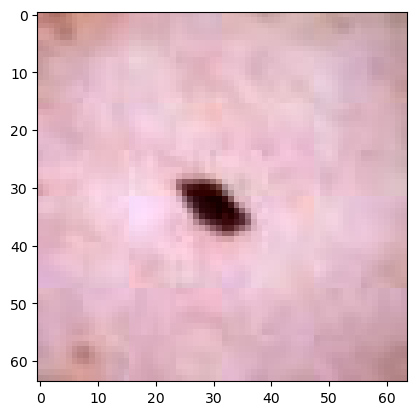

In [6]:
plt.imshow(dataset[0]['image'].permute(1, 2, 0))

In [7]:
random.shuffle(dataset)

train_loader = DataLoader(dataset[0:int(0.8*len(dataset))], batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset[int(0.8*len(dataset)):int(0.9*len(dataset))], batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset[int(0.9*len(dataset)):], batch_size = BATCH_SIZE, shuffle = True)

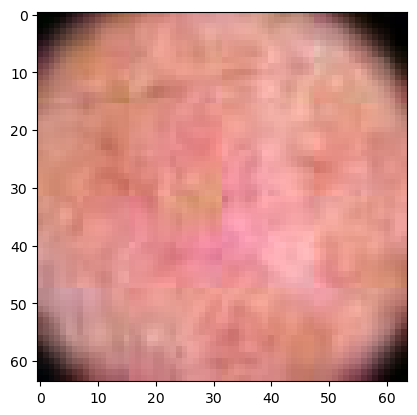

In [8]:
plt.imshow(train_loader.dataset.__getitem__(2)['image'].permute(2,1,0))

## Definición y entrenamiento de la red ResNet50

Cargamos la red ResNet50 original ya entrenada proporcionada por Pytorch y congelamos dichos valores para que no se alteren durante el re-entrenamiento. Creamos una clase que tome esta red y la modifique para que tenga una capa de salida con dos neuronas (clasificación binaria). Entrenamos la red con el conjunto de datos de entrenamiento y validación, y guardamos el modelo con mejor desempeño en la validación.

In [9]:
resnet50_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

for param in resnet50_model.parameters():
    param.requires_grad = False

In [10]:
class New_ResNet50(nn.Module):
    def __init__(self, base_model):
        super(New_ResNet50, self).__init__()
        # Cargamos el modelo pre-entrenado con los parámetros congelados
        # Cambiamos la aquitectura de la capa fully-connected para que tenga 1024 neuronas
        self.base_model = base_model
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1024)

        # Descongelamos los parámetros de la capa fully-connected para que se actualicen durante el entrenamiento
        # ya que hemos cambiado su arquitectura
        for param in self.base_model.fc.parameters():
            param.requires_grad = True

        # Añadimos varias capas fully-connected para la clasificación. Enfoque de transfer learning.
        # https://link.springer.com/article/10.1007/s00521-022-07793-2#Sec14
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return F.softmax(x, dim=1)

Para la tasa de aprendizaje, se usará un valor inicial de 0.001, que se irá reduciendo en un factor de 0.5 si la función de pérdida no disminuye en cada época. Como optimizador se usa Adam con los parámetros de la parte añadida a la red original.

In [11]:
resnet50_model = New_ResNet50(resnet50_model).to(DEVICE)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet50_model.parameters()), lr=0.001)
loss = nn.CrossEntropyLoss(weight = torch.tensor([bening, malignant]).to(DEVICE).float() / (bening + malignant))
lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                        patience=1, threshold=0.0001, threshold_mode='rel', 
                                        cooldown=0, min_lr=0, eps=1e-15, verbose=False)


/opt/anaconda3/envs/tfm/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### Entrenamiento

Almacenamos en respctivas listas los valores de *loss* y *accuracy* durante el entrenamiento de la red tanto para el conjunto de entrenamiento como el de validación.

In [12]:
loss_train_values = []
loss_val_values = []
accuracy_train_values = []
accuracy_val_values = []
lr_values = [] 

for epoch in range(EPOCHS):
    resnet50_model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images_batch = batch['image'].to(DEVICE)
        labels_batch = batch['label'].to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        output = resnet50_model(images_batch)
        loss_value = loss(output, labels_batch.long())
        loss_value.backward()
        optimizer.step()
        epoch_loss += loss_value.item()

        _, predicted = torch.max(output, 1)
        predicted = predicted.cpu().numpy().astype(int)
        labels_batch = labels_batch.cpu().numpy()
        epoch_accuracy += accuracy_score(labels_batch, predicted)

        progress_bar.set_postfix(loss=epoch_loss / (step + 1), accuracy=epoch_accuracy / (step + 1))

    loss_train_values.append(epoch_loss / len(train_loader))
    accuracy_train_values.append(epoch_accuracy / len(train_loader))
    lr_values.append(lr_sch.get_last_lr()[0])

    lr_sch.step(epoch_loss / len(train_loader))

    if (epoch+1) % 5 == 0:
        resnet50_model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        
        with torch.no_grad():
            for step, batch in enumerate(val_loader):
                images_batch = batch['image'].to(DEVICE)
                labels_batch = batch['label'].to(DEVICE)
                output = resnet50_model(images_batch)

                loss_value = loss(output, labels_batch.long())
                val_loss += loss_value.item()
                _, predicted = torch.max(output, 1)
                predicted = predicted.cpu().numpy().astype(int)
                labels_batch = labels_batch.cpu().numpy()
                val_accuracy += accuracy_score(labels_batch, predicted)

        loss_val_values.append(val_loss / len(val_loader))
        accuracy_val_values.append(val_accuracy / len(val_loader))

        print(f"Validation accuracy: {val_accuracy / len(val_loader)}")

Epoch 4: 100%|██████████| 289/289 [00:07<00:00, 38.27it/s, accuracy=0.942, loss=0.37] 


Validation accuracy: 0.9290540540540541


Epoch 9: 100%|██████████| 289/289 [00:07<00:00, 38.32it/s, accuracy=0.95, loss=0.361] 


Validation accuracy: 0.9543918918918919


Epoch 14: 100%|██████████| 289/289 [00:07<00:00, 38.50it/s, accuracy=0.959, loss=0.352]


Validation accuracy: 0.9695945945945946


Epoch 19: 100%|██████████| 289/289 [00:07<00:00, 38.40it/s, accuracy=0.968, loss=0.344]


Validation accuracy: 0.96875


Epoch 24: 100%|██████████| 289/289 [00:07<00:00, 38.49it/s, accuracy=0.972, loss=0.341]


Validation accuracy: 0.9755067567567568


Epoch 29: 100%|██████████| 289/289 [00:07<00:00, 38.55it/s, accuracy=0.977, loss=0.335]


Validation accuracy: 0.9738175675675675


Epoch 34: 100%|██████████| 289/289 [00:07<00:00, 38.39it/s, accuracy=0.975, loss=0.337]


Validation accuracy: 0.9712837837837838


Epoch 39: 100%|██████████| 289/289 [00:07<00:00, 38.52it/s, accuracy=0.974, loss=0.338]


Validation accuracy: 0.9712837837837838


Epoch 44: 100%|██████████| 289/289 [00:07<00:00, 38.50it/s, accuracy=0.975, loss=0.338]


Validation accuracy: 0.972972972972973


Epoch 49: 100%|██████████| 289/289 [00:07<00:00, 38.57it/s, accuracy=0.976, loss=0.336]


Validation accuracy: 0.9771959459459459


Guardamos el modelo de la red alterada para su posterior uso, y almacenamos en un fichero de texto los valores de *loss* y *accuracy* para su posterior análisis y visualización.

In [13]:
# Guardamos el modelo
torch.save(resnet50_model.state_dict(), 'resnet50_ISIC2016_trained.pth')

# Escribir los valores de loss y accuracy para cada una de las épocas en un fichero
empty_string = ""
with open('resnet50_ISIC2016_training_data.csv', 'w') as f:
    f.write('epoch,loss_train,loss_val,accuracy_train,accuracy_val,lr\n')
    i = 0
    for epoch in range(EPOCHS):
        if (epoch+1) % 5 == 0:
            f.write(f"{epoch},{loss_train_values[epoch]},{loss_val_values[i]},{accuracy_train_values[epoch]},{accuracy_val_values[i]},{lr_values[epoch]}\n")
            i+=1
        else:
            f.write(f"{epoch},{loss_train_values[epoch]},{empty_string},{accuracy_train_values[epoch]},{empty_string},{lr_values[epoch]}\n")

In [14]:
resnet50_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for step, batch in enumerate(val_loader):
        images_batch = batch['image'].to(DEVICE)
        labels_batch = batch['label'].to(DEVICE).long()
        y_true += labels_batch.tolist()
        output = resnet50_model(images_batch)
        _, predicted = torch.max(output, 1)
        y_pred += predicted.tolist()

conf_matrix = confusion_matrix(y_true, y_pred)
print(f"Final confusion matrix validation: {conf_matrix}")

Final confusion matrix validation: [[537  13]
 [ 14 590]]


## Prueba del clasificador con el conjunto de test

Por último, ponemos a prueba el clasificador sobre el conjunto de test. 

In [15]:
# Calculamos la matriz de confusión con los datos de validación
resnet50_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for step, batch in enumerate(test_loader):
        images_batch = batch['image'].to(DEVICE)
        labels_batch = batch['label'].to(DEVICE).long()
        y_true += labels_batch.tolist()
        output = resnet50_model(images_batch)
        _, predicted = torch.max(output, 1)
        y_pred += predicted.tolist()

In [16]:
# Calculamos las métricas de evaluación de la clasificación
print("ResNet50 ISIC\n")
accuracy_val = accuracy_score(y_true, y_pred)
print(f"Final accuracy validation: {accuracy_val}")
precision_val = precision_score(y_true, y_pred)
print(f"Final precision validation: {precision_val}")
recall_val = recall_score(y_true, y_pred)
print(f"Final recall validation: {recall_val}")
f1_val = f1_score(y_true, y_pred)
print(f"Final f1 validation: {f1_val}")
conf_matrix = confusion_matrix(y_true, y_pred)
print(f"Final confusion matrix validation: {conf_matrix}")

SkinLesNet ISIC2016

Final accuracy validation: 0.9809358752166378
Final precision validation: 0.9850467289719627
Final recall validation: 0.9741219963031423
Final f1 validation: 0.9795539033457249
Final confusion matrix validation: [[605   8]
 [ 14 527]]
